In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
#!pip install qiskit ipywidgets # while working on google colab!

In [ ]:
# while working on google colab, run this cell
#!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils_2.py

In [89]:
from qbm_utils_2 import *

### Define the model

In [91]:
# define the model
np.random.seed(1)# should always be in the same cell!
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.     0.13  -0.105 -0.695]
 [ 0.13   0.     0.745 -0.57 ]
 [-0.105  0.745  0.    -0.465]
 [-0.695 -0.57  -0.465  0.   ]]
h is: [-0.17 -0.88  0.04  0.58]
alpha:  1.206396381047913


### Get the true distribution

In [92]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    #plot_histogram([boltz_prob_distn], legend=["analytical"], sort="value_desc")
    plot_bargraph_desc_order(boltz_prob_distn, label="analytical",plot_first_few=20); plt.legend()
    return boltz_prob_distn

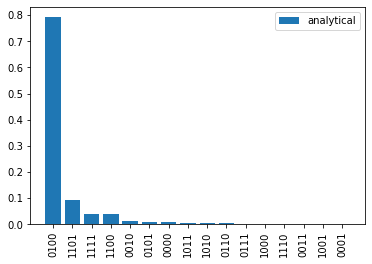

In [93]:
states_nbit=states(num_spins=n_spins)
temp=0.5
boltz_prob_distn=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)

In [94]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  -1.2889977364022813


### Function to run different number of chains of mcmc for a particular problem instance

In [95]:
def run_mcmc_different_chains_cl(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int, return_both=False):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram

    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=cl_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=cl_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [98]:
dict_sep_chains_distn, dict_sep_chain_sprime, dict_sep_chains_accepted, dict_sep_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains_cl(n_spins, 6, 3, model, temp=temp, return_last_n_states=6, return_both=True )

100%|██████████| 3/3 [00:00<00:00, 59.85it/s]

starting with:  1101
starting with:  1100
starting with:  0111


In [99]:
print("dict_sep_chains_distn:")
print(dict_sep_chains_distn)
print("dict_sep_chains_sprime:")
print(dict_sep_chain_sprime)
print("dict_sep_chains_accepted:")
print(dict_sep_chains_accepted)
print("dict_sep_chains_energy_diff_s_and_sprime:")
print(dict_sep_chains_energy_diff_s_and_sprime)
print("dict_seperate_chains_counts_based_on_hamming_dist:")
print(dict_seperate_chains_counts_based_on_hamming_dist)

dict_sep_chains_distn:
{0: {'1101': 3, '0100': 3}, 1: {'0100': 4, '1100': 2}, 2: {'1100': 4, '0111': 2}}
dict_sep_chains_sprime:
{0: ['0011', '1101', '0100', '0010', '0101', '1101'], 1: ['1011', '0100', '1101', '0000', '0000', '0111'], 2: ['1001', '1100', '1100', '1100', '0010', '0010']}
dict_sep_chains_accepted:
{0: ['1101', '1101', '0100', '0100', '0100', '0100'], 1: ['1100', '0100', '0100', '0100', '0100', '0100'], 2: ['0111', '1100', '1100', '1100', '1100', '0010']}
dict_sep_chains_energy_diff_s_and_sprime:
{0: array([3.78, 1.08, 0.  , 2.1 , 2.34]), 1: array([2.66, 0.  , 1.08, 2.37, 2.37]), 2: array([3.69, 0.  , 0.  , 0.  , 0.  ])}
dict_seperate_chains_counts_based_on_hamming_dist:
{0: {0: 1, 1: 1, 2: 3, 3: 0, 4: 0}, 1: {0: 0, 1: 3, 2: 2, 3: 0, 4: 0}, 2: {0: 2, 1: 0, 2: 0, 3: 3, 4: 0}}
